# Intrinsic Dimensionality & Readability

Here, we take Intrinsic Dimensionality to correspond to the number of dimensions that explain 95% of the variance of the embedding matrices that represent passages from the CLEAR corpus. 

We embed passages using a bidirectional transformer model architecture, RoBERTa. 

In [1]:
%reset
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

import functools
import os
import torch
import transformers

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from transformers import AutoTokenizer


### Seaborn theme
sns.set(style="white", font_scale=1.2)


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
### Styling
# Get the Mako palette
palette = sns.color_palette("mako", 3)

# Select colors from opposite ends
color1 = palette[0]  # First color
color2 = palette[-1] # Last color
color3 = palette[3 // 2]

### Define some useful custom functions

In [3]:
### Define useful custom functions to ...

# Count model parameters
def count_parameters(model):
    """credit: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model"""
    
    total_params = 0
    for name, parameter in model.named_parameters():
        
        # if the param is not trainable, skip it
        if not parameter.requires_grad:
            continue
        
        # otherwise, count it towards your number of params
        params = parameter.numel()
        total_params += params
    print(f"Total Trainable Params: {total_params}")
    
    return total_params

from sklearn.decomposition import PCA


# Compute intrinsic dimensionality of embeddings

def compute_intrdim_pca(embedding_matrix):
    "credit: Claude-Anthropic"
    
    # Perform PCA
    pca = PCA()
    pca.fit(embedding_matrix)

    # Compute cumulative explained variance ratio
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components needed to explain 95% of the variance
    intrinsic_dim = np.argmax(cumulative_variance_ratio >= 0.95) + 1

#     print(f"Intrinsic dimensionality (95% explained variance): {intrinsic_dim}")

    return intrinsic_dim

### Load the Readability Dataset

In [4]:
df = pd.read_csv("../data/raw/CLEAR_corpus_final.csv")
df.head(3)

,ID,Author,Title,Anthology,URL,Pub Year,Categ,Sub Cat,Lexile Band,Location,...,BT_easiness,s.e.,Flesch-Reading-Ease,Flesch-Kincaid-Grade-Level,Automated Readability Index,SMOG Readability,New Dale-Chall Readability Formula,CAREC,CAREC_M,CML2RI
0,400,Carolyn Wells,Patty's Suitors,NaN,http://www.gutenberg.org/cache/epub/5631/pg563...,1914.0,Lit,NaN,900,mid,...,-0.340259,0.464009,81.70,5.95,7.37,8.0,6.55,0.12102,0.11952,12.097815
1,401,Carolyn Wells,Two Little Women on a Holiday,NaN,http://www.gutenberg.org/cache/epub/5893/pg589...,1917.0,Lit,NaN,700,mid,...,-0.315372,0.480805,80.26,4.86,4.16,7.0,6.25,0.04921,0.04921,22.550179
2,402,Carolyn Wells,Patty Blossom,NaN,http://www.gutenberg.org/cache/epub/20945/pg20...,1917.0,Lit,NaN,900,mid,...,-0.580118,0.476676,79.04,6.03,5.81,9.0,7.31,0.10172,0.09724,18.125279


### Embed Excerpts Using an LLM

In [5]:
MODELS = ["FacebookAI/roberta-base"]

In [225]:
# Decide which device to allocate models to
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

for mpath in tqdm(MODELS, colour="cornflowerblue"):
    
    print(mpath)
    
    # Load model & tokenizer from HuggingFace 
    model = transformers.AutoModel.from_pretrained(mpath,output_hidden_states=True)
    model.to(device) #allocate model to desired device
    
    tokenizer = transformers.AutoTokenizer.from_pretrained(mpath)
    
    # Get some model details to save later
    mname = mpath.split("/")[-1]
    n_layers = model.config.num_hidden_layers
    n_params = count_parameters(model)
    
    # Iterate through data passages
    results = []
    for ix,row in tqdm(df.iterrows(),total=df.shape[0],colour="hotpink"): 
        
        excerpt = row["Excerpt"]
        
        # Tokenize excerpt
        inputs = tokenizer(excerpt, return_tensors="pt").to(device)

        # Run model
        with torch.no_grad():
            output = model(**inputs)
            hidden_states = output.hidden_states
            
        # Iterate through model layers
        intrinsic_dims = []
        for layer in range(n_layers+1): 
            
            # Grab layer-specific embeddings
            layer_embed = hidden_states[layer][0]
            
            # Compute intrinsic dimensionality for excerpt-layer combination
            intrinsic_dim = compute_intrdim_pca(layer_embed.detach().cpu())
            
            
            results.append({"Model_name": mname,
                 "Layer": layer,
                 "Intrinsic_dim": intrinsic_dim,
                 "Excerpt": excerpt
                })
        
    
    df_results = pd.DataFrame(results) 
        
    ### Save 
    savepath = "../data/processed/intrinsic_dim/"
    if not os.path.exists(savepath): 
        os.mkdir(savepath)

    filename = "readability_id_model-" + mpath.split("/")[1] + ".csv"

    df_results.to_csv(os.path.join(savepath,filename), index=False)       
    

In [6]:
# JUMP HERE ... If you've already run the models above

datapath = "../data/processed/intrinsic_dim/"
filename = "readability_id_model-roberta-base.csv"

# gather_dfs = []
# for file in files: 
    
#     tmp = pd.read_csv(os.path.join(datapath,file))
#     gather_dfs.append(tmp)
    
# df_results = pd.concat(gather_dfs)

df_results = pd.read_csv(os.path.join(datapath,filename))

In [217]:
df_results


,Model_name,Layer,Intrinsic_dim,Excerpt
0,roberta-base,0,107,When the young people returned to the ballroom...
1,roberta-base,1,113,When the young people returned to the ballroom...
2,roberta-base,2,122,When the young people returned to the ballroom...
3,roberta-base,3,128,When the young people returned to the ballroom...
4,roberta-base,4,125,When the young people returned to the ballroom...
...,...,...,...,...
61407,roberta-base,8,104,Animals are made of many cells. They eat thing...
61408,roberta-base,9,104,Animals are made of many cells. They eat thing...
61409,roberta-base,10,105,Animals are made of many cells. They eat thing...
61410,roberta-base,11,98,Animals are made of many cells. They eat thing...


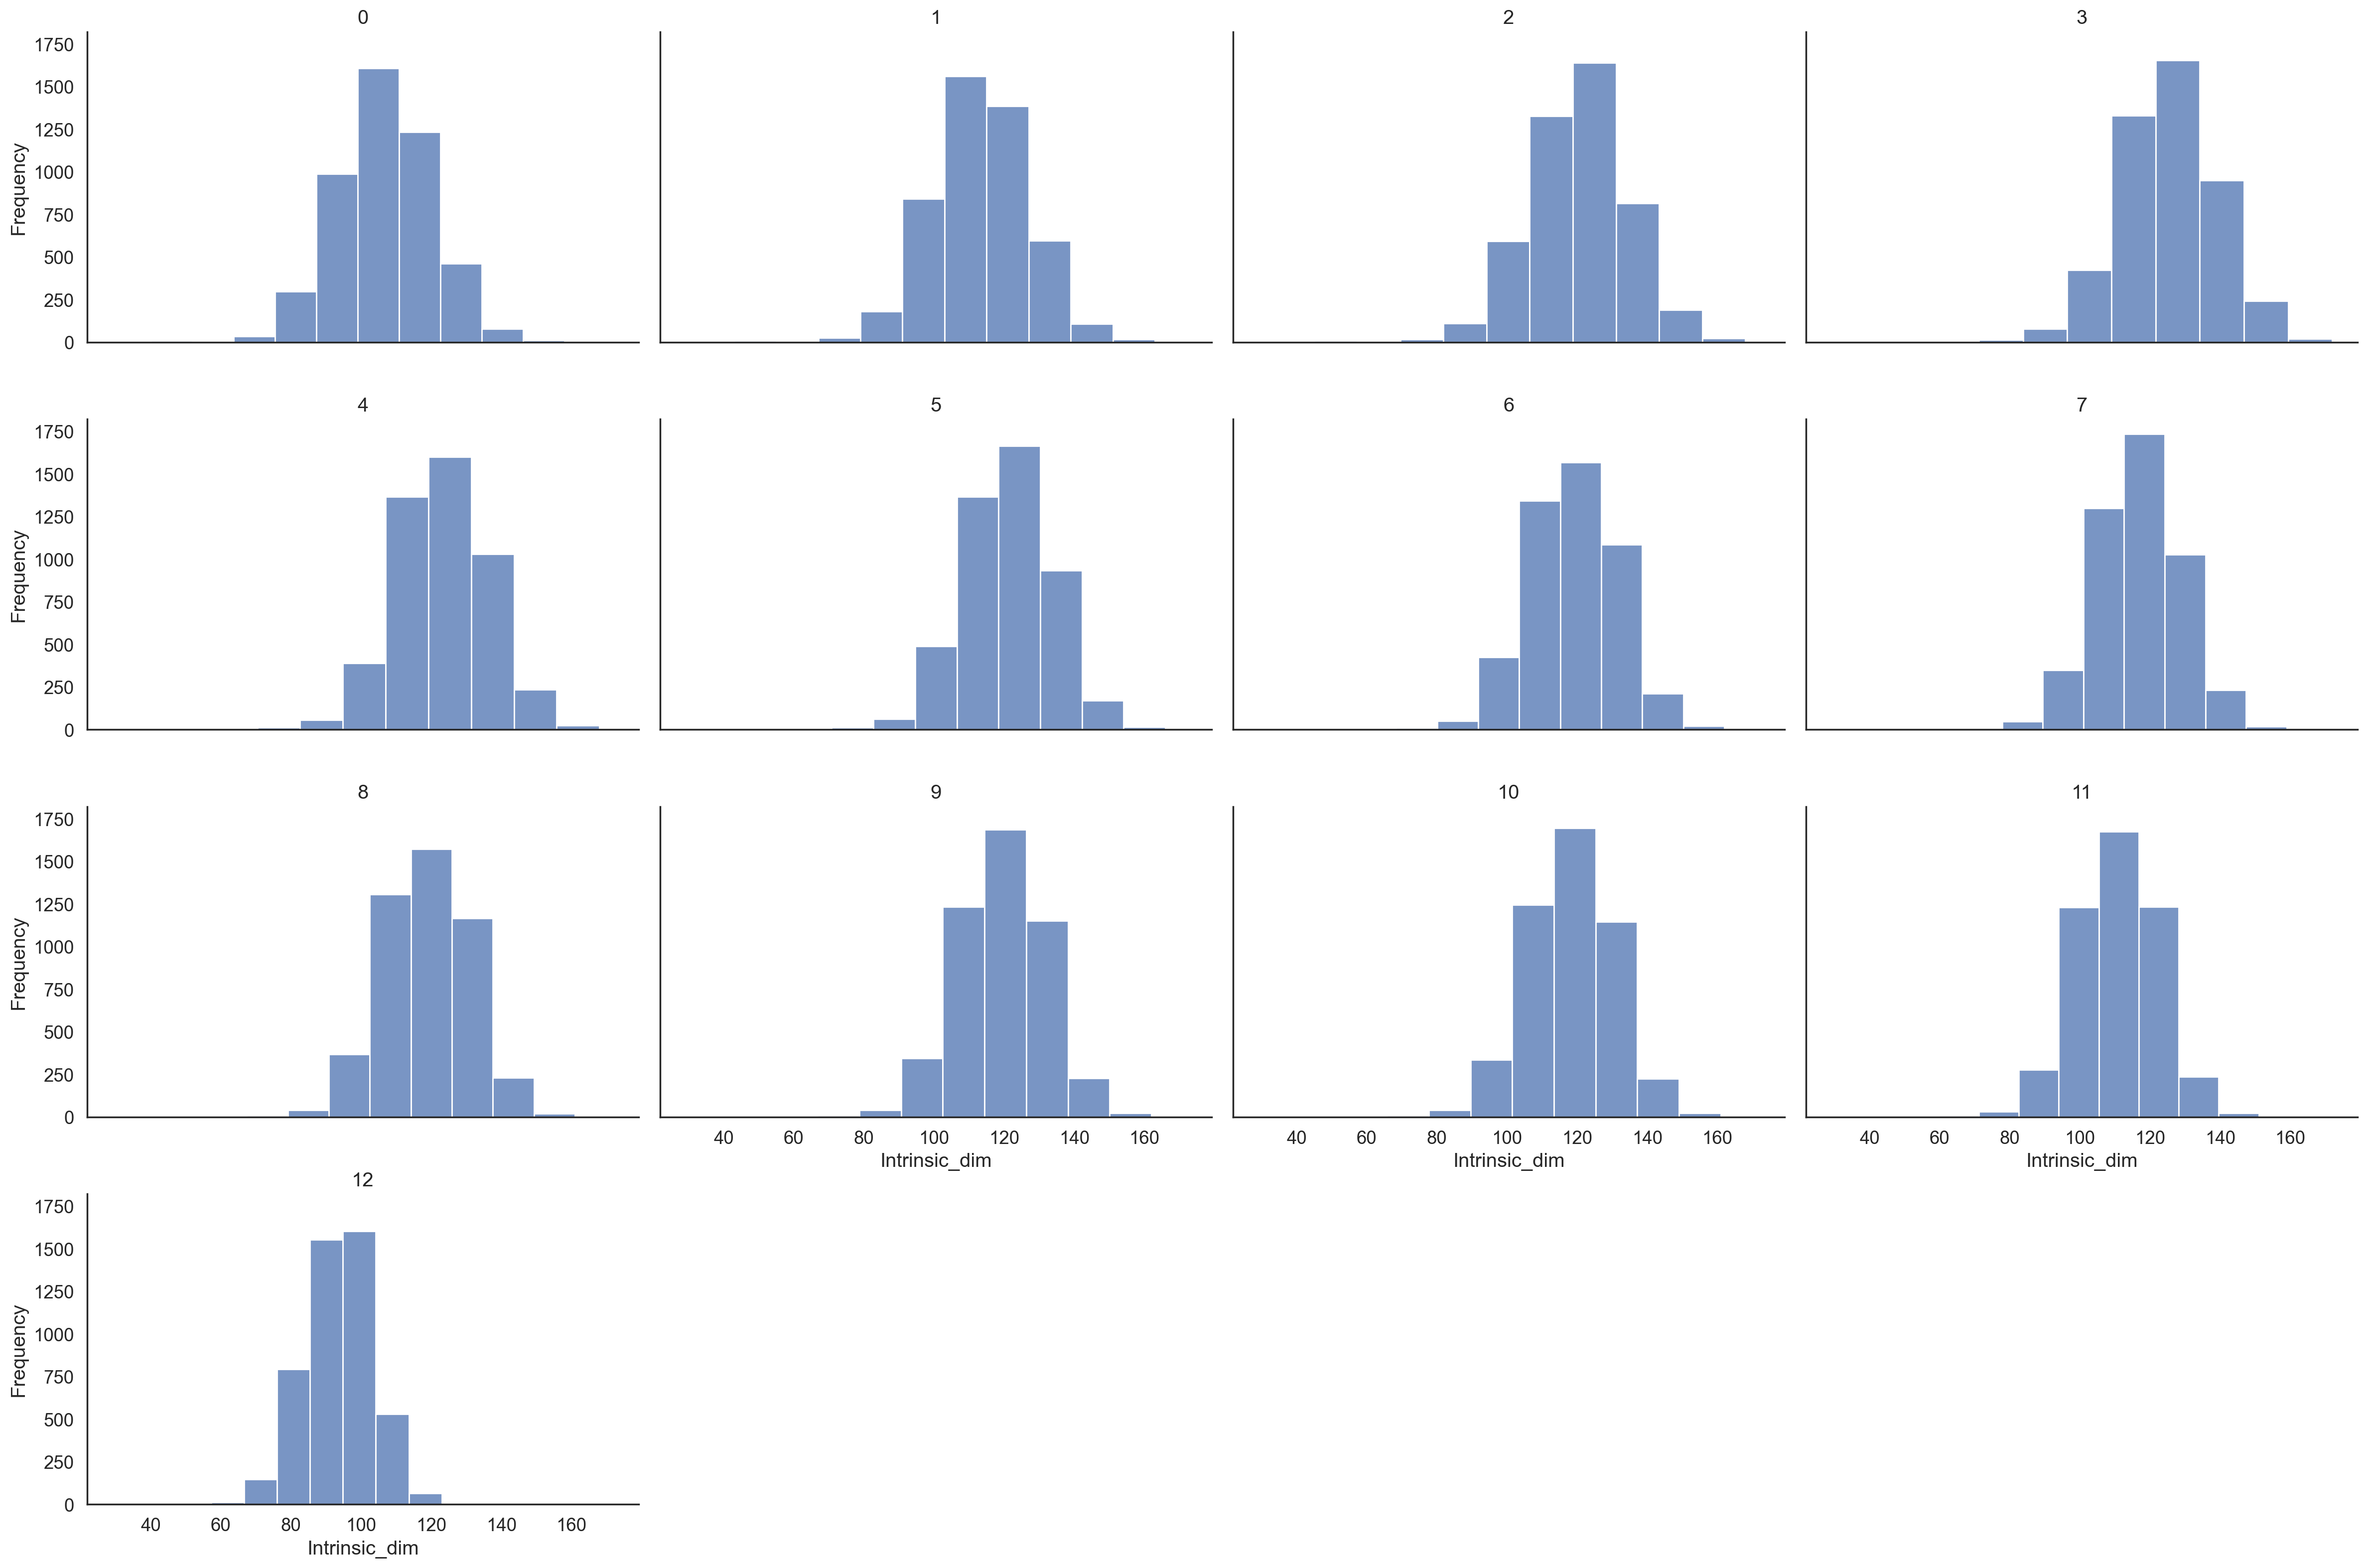

In [219]:
g = sns.FacetGrid(df_results, col="Layer", col_wrap=4, height=4, aspect=1.5)
g.map_dataframe(sns.histplot, x="Intrinsic_dim", bins=10)
g.set_axis_labels("Intrinsic_dim", "Frequency")
g.set_titles(col_template="{col_name}")
# plt.show()

<AxesSubplot:xlabel='Layer', ylabel='Intrinsic_dim'>

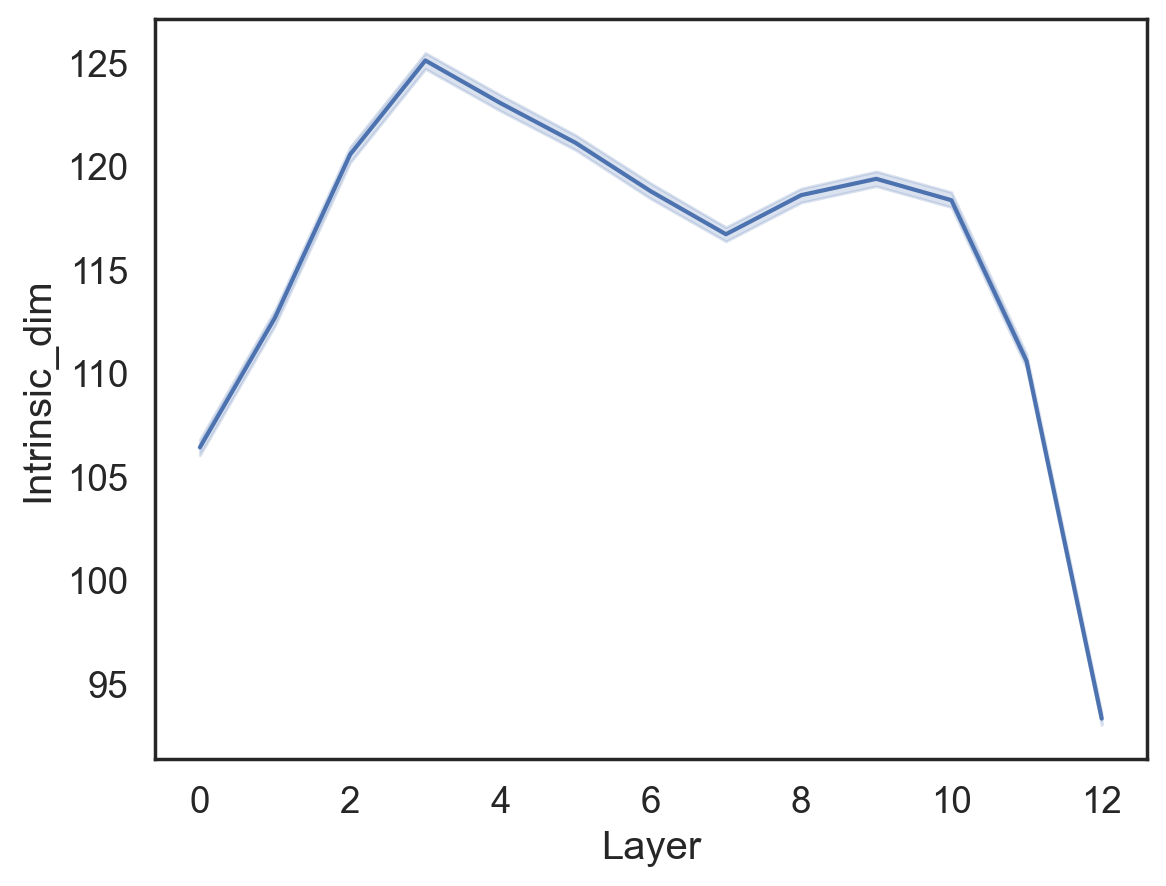

In [220]:
sns.lineplot(data = df_results, x = "Layer", y = "Intrinsic_dim")

In [221]:
df_merged = pd.merge(df_results, df)
df_merged.head(2)

,Model_name,Layer,Intrinsic_dim,Excerpt,ID,Author,Title,Anthology,URL,Pub Year,...,BT_easiness,s.e.,Flesch-Reading-Ease,Flesch-Kincaid-Grade-Level,Automated Readability Index,SMOG Readability,New Dale-Chall Readability Formula,CAREC,CAREC_M,CML2RI
0,roberta-base,0,107,When the young people returned to the ballroom...,400,Carolyn Wells,Patty's Suitors,NaN,http://www.gutenberg.org/cache/epub/5631/pg563...,1914.0,...,-0.340259,0.464009,81.7,5.95,7.37,8.0,6.55,0.12102,0.11952,12.097815
1,roberta-base,1,113,When the young people returned to the ballroom...,400,Carolyn Wells,Patty's Suitors,NaN,http://www.gutenberg.org/cache/epub/5631/pg563...,1914.0,...,-0.340259,0.464009,81.7,5.95,7.37,8.0,6.55,0.12102,0.11952,12.097815


In [222]:
df_merged.columns

Index(['Model_name', 'Layer', 'Intrinsic_dim', 'Excerpt', 'ID', 'Author',
       'Title', 'Anthology', 'URL', 'Pub Year', 'Categ', 'Sub Cat',
       'Lexile Band', 'Location', 'License', 'MPAA Max', 'MPAA #Max',
       'MPAA# Avg', 'Google WC', 'Sentence Count', 'Paragraphs', 'BT_easiness',
       's.e.', 'Flesch-Reading-Ease', 'Flesch-Kincaid-Grade-Level',
       'Automated Readability Index', 'SMOG Readability',
       'New Dale-Chall Readability Formula', 'CAREC', 'CAREC_M', 'CML2RI'],
      dtype='object')

In [223]:
ss.pearsonr(df_merged['BT_easiness'], df_merged['Intrinsic_dim'])

PearsonRResult(statistic=-0.2716554432282147, pvalue=0.0)

<AxesSubplot:xlabel='Categ', ylabel='Intrinsic_dim'>

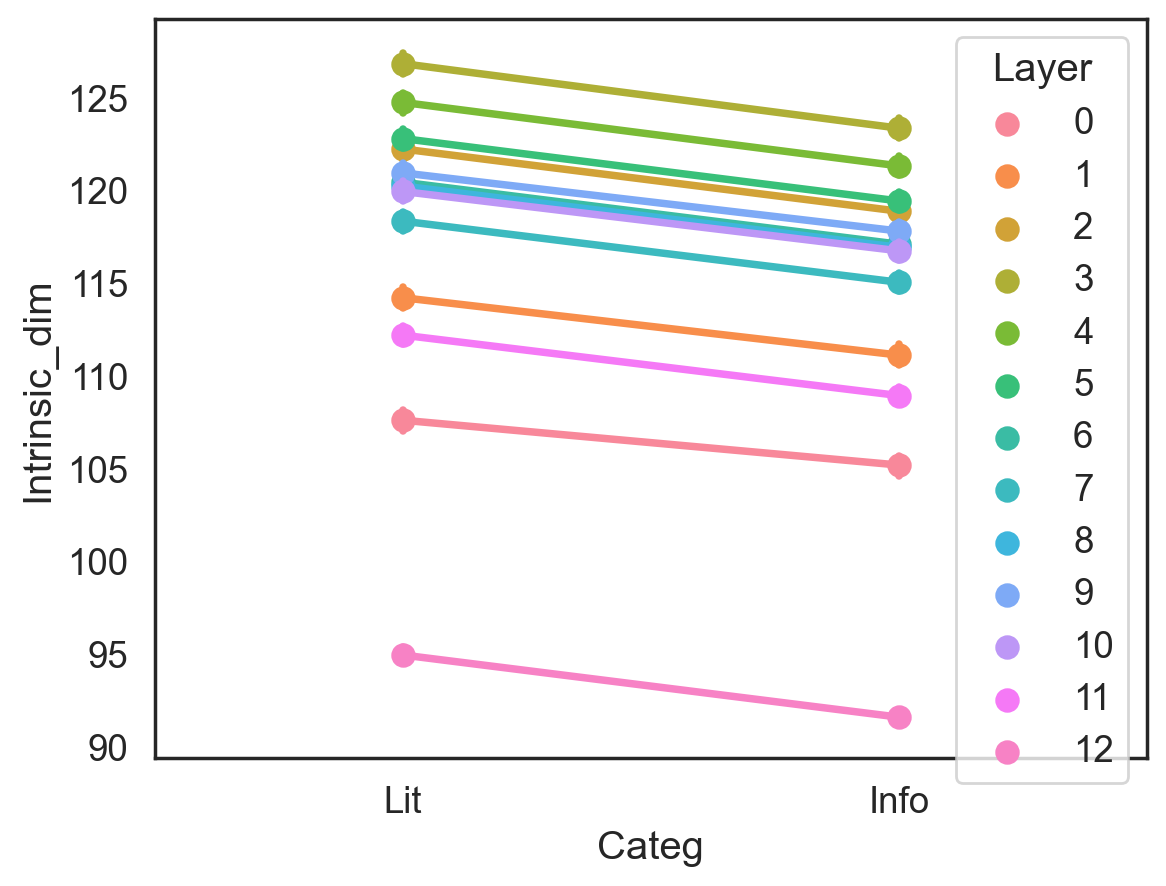

In [224]:
sns.pointplot(data = df_merged, 
           x = "Categ", y = "Intrinsic_dim", hue = "Layer")